# Домашнее задание

Работа с sentence-transformers

**Цель:**

Закрепить навыки работы с библиотекой SentenceTransformers для создания эмбеддингов текста, выполнения задач семантического поиска, вычисления текстового сходства, поиска парафраз и дополнительных NLP-задач.

## Описание/Пошаговая инструкция выполнения домашнего задания:


- Датасеты (HuggingFace)

    - Для английского языка: sentence-transformers/embedding-training-data (выбирайте небольшие поднаборы, например, случайные 10-20 предложений из раздела gooaq_pairs для эмбеддингов)
    - Для русского языка [датасеты](https://huggingface.co/collections/ai-forever/ru-mteb-6650a6a6708dc5107a9e0ba3) из RU-MTEB;
---

- Модели (HuggingFace)

    - Для английского all-MiniLM-L6-v2 (или другую по вашему выбору, например, paraphrase-multilingual-MiniLM-L12-v2
    - Для русского [ru-en-RosBERTa](https://huggingface.co/ai-forever/ru-en-RoSBERTa/tree/main) и [FRIDA](https://huggingface.co/ai-forever/FRIDA)

Также модели можно брать на основании статьи [ruMTEB](https://arxiv.org/abs/2408.12503)

## 1. Установка и настройка окружения

In [198]:
import random
import numpy as np

import torch
from datasets import Dataset, DatasetDict, load_dataset

from sentence_transformers import SentenceTransformer, util

import seaborn as sns
import matplotlib.pyplot as plt

Поскольку в статье [ruMTEB](https://arxiv.org/abs/2408.12503) авторы представляют модель [ru-en-RosBERTa](https://huggingface.co/ai-forever/ru-en-RoSBERTa/tree/main), то ее и будем использовать в дальнейших экспериментах

In [6]:
base_model = "ai-forever/ru-en-RoSBERTa"

## 2. Получение эмбеддингов текста
    • Загрузите предобученную модель all-MiniLM-L6-v2 (или другую по вашему выбору из раздела модели).
    • На основе одного из датасетов из раздела датасеты создайте список из 10–15 предложений.
    • Получите эмбеддинги для этих предложений с помощью метода encode.
    • Выведите размерность полученных эмбеддингов и их первые несколько значений.

In [8]:
model = SentenceTransformer(base_model)

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False, 'architecture': 'RobertaModel'})
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [11]:
path = "data/headline-classification/"
data_files={"train": path+"train.jsonl", "validation": path+"validation.jsonl", "test": path+"test.jsonl"}
data_files

{'train': 'data/headline-classification/train.jsonl',
 'validation': 'data/headline-classification/validation.jsonl',
 'test': 'data/headline-classification/test.jsonl'}

In [12]:
headline_dataset = load_dataset("json", data_files=data_files)
headline_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 36000
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 12000
    })
})

In [ ]:
#import random

# # Generate 10 random indices
# num_samples = 10
# random_indices = random.sample(range(len(train_dataset)), num_samples)

# # Select the random samples
# random_samples = headline_dataset['test'].select(random_indices)
# print(random_samples["text"])

In [62]:
sentences = headline_dataset['test']['text'][:15]
sentences

['Преступник устроил перестрелку в американской парикмахерской',
 'Вещи режиссера фильма "Гражданин Кейн" выставят на торги в Нью-Йорке',
 'Курсы банковских металлов НБУ на 13 декабря 2011 года',
 'Борис Михайлов: "Отставка Назарова неожиданностью не стала"',
 'Уровень бедности в России в I квартале подскочил до 16%',
 'В Алтайском крае также ищут обломки "Прогресса"',
 'Доходы России от экспорта нефти сократились вдвое в январе',
 'Хоккей. Владимир Шалаев: Назарову грозили 5-7 игр дисквалификации',
 'Доказана польза кофе в борьбе с ожирением',
 'Китайский космический корабль "Шэньчжоу-11" успешно состыковался с лабораторным модулем "Тяньгун-2"',
 'Стив Джобс посмертно получит музыкальную премию "Грэмми"',
 'Совместный полет МКС-"Дискавери" продлен на сутки - НАСА',
 'На российском рынке появился смартфон Philips Xenium V526',
 'Меркель назвала условие снятия антироссийских санкций',
 'Хоккей: Команда Павла Дацюка вылетела из Кубка Стэнли']

In [64]:
embeddings = model.encode(sentences)
print(f"Shape of embeddings: {embeddings.shape}")
print(f"First embedding: {embeddings[0][:5]}")

Shape of embeddings: (15, 1024)
First embedding: [0.01600719 0.00808946 0.03669386 0.03926603 0.03174081]


## 3. Семантическое текстовое сходство (1 балл)
    • Используя эмбеддинги из предыдущего шага, вычислите косинусное сходство между всеми парами предложений с помощью функции util.cos_sim.
    • Выведите матрицу сходства и определите, какие два предложения наиболее похожи по смыслу.

In [66]:
cosine_scores = util.cos_sim(embeddings, embeddings)

In [68]:
print("Cosine Similarity Matrix:")
print(cosine_scores)

Cosine Similarity Matrix:
tensor([[1.0000, 0.4596, 0.2920, 0.3640, 0.3205, 0.3191, 0.2808, 0.3389, 0.2933,
         0.2851, 0.4256, 0.2826, 0.3516, 0.2639, 0.3144],
        [0.4596, 1.0000, 0.4498, 0.4072, 0.3081, 0.3730, 0.3486, 0.3561, 0.3623,
         0.3190, 0.4392, 0.3810, 0.3302, 0.3485, 0.3433],
        [0.2920, 0.4498, 1.0000, 0.4018, 0.4221, 0.3393, 0.4274, 0.3959, 0.3338,
         0.3206, 0.2837, 0.3460, 0.3644, 0.3799, 0.4134],
        [0.3640, 0.4072, 0.4018, 1.0000, 0.3757, 0.3626, 0.3699, 0.7002, 0.3552,
         0.2793, 0.3941, 0.3399, 0.3012, 0.4361, 0.4492],
        [0.3205, 0.3081, 0.4221, 0.3757, 1.0000, 0.3440, 0.5165, 0.3697, 0.3288,
         0.2529, 0.2132, 0.3065, 0.3329, 0.3419, 0.3372],
        [0.3191, 0.3730, 0.3393, 0.3626, 0.3440, 1.0000, 0.3239, 0.3855, 0.3565,
         0.5409, 0.3457, 0.5081, 0.3877, 0.3183, 0.3857],
        [0.2808, 0.3486, 0.4274, 0.3699, 0.5165, 0.3239, 1.0000, 0.3972, 0.3727,
         0.2637, 0.2615, 0.3147, 0.4172, 0.3832, 0.4193],
 

Визуализируем полученные данные

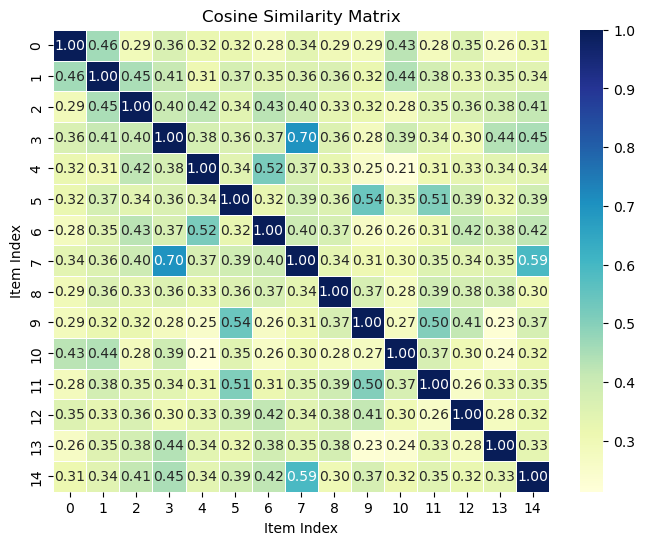

In [71]:
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(cosine_scores, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("Cosine Similarity Matrix")
plt.xlabel("Item Index")
plt.ylabel("Item Index")
plt.show()

In [43]:
sentences[3], sentences[7]

('Борис Михайлов: "Отставка Назарова неожиданностью не стала"',
 'Хоккей. Владимир Шалаев: Назарову грозили 5-7 игр дисквалификации')

Тут случайное совпадение фамилии...

In [45]:
sentences[5], sentences[9]

('В Алтайском крае также ищут обломки "Прогресса"',
 'Китайский космический корабль "Шэньчжоу-11" успешно состыковался с лабораторным модулем "Тяньгун-2"')

А вот это уже гораздо лучше, оба текстовых фрагмента на космическую тему.

In [73]:
sentences[7], sentences[14]

('Хоккей. Владимир Шалаев: Назарову грозили 5-7 игр дисквалификации',
 'Хоккей: Команда Павла Дацюка вылетела из Кубка Стэнли')

Тут тоже все ОК, спортивная тематика.

## 4. Семантический поиск
- На основе одного из датасетов из раздела датасеты создайте список из 15-20 предложений (например, описания фильмов, книг, статей или постов из социальных сетей).
- Сформулируйте 3–4 поисковых запроса, связанных с темой корпуса (например, "научная фантастика" для корпуса описаний фильмов).
- Получите эмбеддинги корпуса и запросов.
- Используйте функцию util.semantic_search, чтобы найти топ-3 наиболее релевантных текста для каждого запроса.
- Выведите результаты с указанием текстов и их оценок сходства.

In [92]:
corpus = headline_dataset['test']['text']
queries = ["политика", "экономика", "наука", "спорт"]

In [94]:
corpus_embeddings = model.encode(corpus)
query_embeddings = model.encode(queries)

In [96]:
hits = util.semantic_search(query_embeddings, corpus_embeddings, top_k=3)

In [103]:
hits[0]

[{'corpus_id': 3513, 'score': 0.6507707834243774},
 {'corpus_id': 360, 'score': 0.6385994553565979},
 {'corpus_id': 3146, 'score': 0.6108406186103821}]

In [149]:
for query, hit in zip(queries, hits):
    print(f"\nТема: {query}")
    for h in hit:
        print(f"Score: {h['score']:.3f}, Text: {corpus[h['corpus_id']]}")


Тема: политика
Score: 0.651, Text: Хроника выборов. Онлайн
Score: 0.639, Text: Минюст разъяснил понятие политической деятельности НКО
Score: 0.611, Text: Медведев хочет менять политсистему в России

Тема: экономика
Score: 0.686, Text: Bank of America: Российская экономика восстанавливается
Score: 0.670, Text: Экономика России набирает обороты: Путин поговорил с бизнесменами в Кремле
Score: 0.649, Text: Экономика России может вступить в рецессию уже в 2012 г

Тема: наука
Score: 0.660, Text: Ученые опровергли 5 самых популярных научных мифов
Score: 0.630, Text: Ученые заявили, что уровень интеллекта человечества снижается
Score: 0.625, Text: Россия увеличивает финансирование фундаментальных научных исследований

Тема: спорт
Score: 0.651, Text: Техника молодежи
Score: 0.645, Text: Заседание Совета по развитию физической культуры и спорта
Score: 0.630, Text: Игра в догонялки


## 5. Поиск парафраз
- Возьмите корпус из 20–30 предложений (можно использовать тот же, что в задании 4, или новый на основе датасетов из раздела датасеты).
- Используйте функцию util.paraphrase_mining, чтобы найти пары предложений, которые являются парафразами (имеют близкий смысл).
- Выведите топ-5 пар с наивысшими оценками сходства и соответствующими предложениями.

In [141]:
paraphrases = util.paraphrase_mining(model, corpus[:100])

In [147]:
paraphrases[:5]

[[0.7001790404319763, 3, 7],
 [0.6889865398406982, 18, 31],
 [0.6566447019577026, 22, 33],
 [0.6401084065437317, 19, 51],
 [0.6357138156890869, 15, 52]]

In [145]:
for score, i, j in paraphrases[:5]:
    print(f"Score: {score:.3f}\nHeadline 1: {corpus[i]}\nHeadline 2: {corpus[j]}\n")

Score: 0.700
Headline 1: Борис Михайлов: "Отставка Назарова неожиданностью не стала"
Headline 2: Хоккей. Владимир Шалаев: Назарову грозили 5-7 игр дисквалификации

Score: 0.689
Headline 1: Азаров считает, что евроинтеграции мешает блокирование Кабмина и Рады
Headline 2: Азаров: альтернатива России есть, а выбора нет

Score: 0.657
Headline 1: В Лос-Анджелесе началась 59-я церемония вручения музыкальных премий Grammy
Headline 2: Леди Гага получила престижнейшие Grammy

Score: 0.640
Headline 1: Рубль в начале дня вырос на 3 коп к доллару и упал на 3 коп к евро
Headline 2: Евро опустился ниже 55 рублей

Score: 0.636
Headline 1: Фильм венесуэльского режиссера Лоренцо Вигаса "Отсюда" стал обладателем главной награды Венецианского фестиваля
Headline 2: Открылся 70-й Венецианский кинофестиваль



## 6. Кластеризация текстов
- Используя тот же корпус из 15–20 текстов, выполните кластеризацию текстов по их эмбеддингам с помощью функции util.community_detection из SentenceTransformers.
- Установите минимальный размер кластера (min_community_size=2) и порог сходства (threshold=0.75).
- Выведите полученные кластеры и соответствующие им тексты.
- Проанализируйте, насколько логично тексты были сгруппированы (например, объединяются ли тексты с похожей тематикой).

In [167]:
clusters = util.community_detection(corpus_embeddings[:500], min_community_size=2, threshold=0.75)

In [186]:
len(clusters), clusters

(10,
 [[19, 334],
  [92, 391],
  [137, 429],
  [152, 218],
  [194, 488],
  [276, 474],
  [314, 421],
  [321, 478],
  [340, 440],
  [372, 480]])

In [171]:
for i, cluster in enumerate(clusters):
    print(f"\nCluster {i + 1}:")
    for idx in cluster:
        print(f" - {corpus[idx]}")


Cluster 1:
 - Рубль в начале дня вырос на 3 коп к доллару и упал на 3 коп к евро
 - Российский рубль во вторник продолжил укрепление

Cluster 2:
 - Режиссер из Владивостока стал победителем кинофестиваля "Кинотавр"
 - Никита Михалков стал лауреатом Одесского международного кинофестиваля 16.07.2011

Cluster 3:
 - Apple отозвала обновление iOS 8 после жалоб пользователей
 - Apple отозвала обновление iOS 8.0.1 после многочисленных жалоб

Cluster 4:
 - Установлены личности боевиков, уничтоженных в Малгобекском районе Ингушетии
 - Один из злоумышленников, пытавшихся похитить имама мечети в дагестанском селении Кахабросо, был уничтожен в ходе перестрелки

Cluster 5:
 - Межбанк закрылся на уровне 25,84/25,88 грн за доллар
 - Торги на межбанке открылись в диапазоне 7,9910-7,9945 грн/долл

Cluster 6:
 - Спасатели потушили 11 природных пожаров в Приморском крае
 - За минувшие сутки в Хабаровском крае ликвидировали 10 лесных пожаров

Cluster 7:
 - Huawei анонсировала недорогой смартфон Honor 7X 

## Дописать анализ адекватности кластеризации

## 7. Классификация текстов (дополнительное бонусное задание)
- На основе одного из датасетов из раздела датасеты создайте небольшой набор данных из 10–15 пар предложений, где каждая пара помечена как "похожие" (1) или "непохожие" (0) по смыслу.
- Получите эмбеддинги для каждой пары предложений и вычислите их косинусное сходство.
- Используйте порог (например, 0.7), чтобы классифицировать пары как похожие или непохожие.
- Сравните ваши предсказания с истинными метками и вычислите точность (accuracy) классификации.

In [194]:
len(corpus)

12000

In [192]:
corpus[19], corpus[334]

('Рубль в начале дня вырос на 3 коп к доллару и упал на 3 коп к евро',
 'Российский рубль во вторник продолжил укрепление')

In [204]:
random.randint(0, len(corpus)-1)

11847

In [216]:
for i, cluster in enumerate(clusters):
    print(i, cluster[0])

0 19
1 92
2 137
3 152
4 194
5 276
6 314
7 321
8 340
9 372


In [232]:
# Let's write small function to create a dataset of pairs for similar and different sentences with labels
def make_pairs(clusters, pairs_max_num=10):
    pairs = []
    for i, cluster in enumerate(clusters):
        sim_pair = [corpus[cluster[0]], corpus[cluster[1]], 1]
        dif_pair = [corpus[cluster[0]], corpus[random.randint(0, len(corpus)-1)], 0]
        pairs.extend([sim_pair, dif_pair])
        if i >= pairs_max_num:
            return pairs
    return pairs    

In [236]:
pairs = make_pairs(clusters)

20

In [246]:
len(pairs), pairs

(20,
 [['Рубль в начале дня вырос на 3 коп к доллару и упал на 3 коп к евро',
   'Российский рубль во вторник продолжил укрепление',
   1],
  ['Рубль в начале дня вырос на 3 коп к доллару и упал на 3 коп к евро',
   'Шеститонный неуправляемого спутник NASA упадет в Индийский океан',
   0],
  ['Режиссер из Владивостока стал победителем кинофестиваля "Кинотавр"',
   'Никита Михалков стал лауреатом Одесского международного кинофестиваля 16.07.2011',
   1],
  ['Режиссер из Владивостока стал победителем кинофестиваля "Кинотавр"',
   '"Полиция убивает". Пьяные сотрудники МВД Украины застрелили ребенка',
   0],
  ['Apple отозвала обновление iOS 8 после жалоб пользователей',
   'Apple отозвала обновление iOS 8.0.1 после многочисленных жалоб',
   1],
  ['Apple отозвала обновление iOS 8 после жалоб пользователей',
   'Северный полюс Земли начал двигаться на восток, - ученые',
   0],
  ['Установлены личности боевиков, уничтоженных в Малгобекском районе Ингушетии',
   'Один из злоумышленников, пыт

Датасет с парами фраз и метками готов, можно генерировать предсказания и считать accuracy

In [250]:
predictions = []
for sent1, sent2, label in pairs:
    emb1, emb2 = model.encode([sent1, sent2])
    score = util.cos_sim(emb1, emb2)[0][0]
    pred = 1 if score > 0.7 else 0
    predictions.append(pred)
    print(f"Новость 1: {sent1}\nНовость 2: {sent2}\nScore: {score:.3f}, Predicted: {pred}, True: {label}\n")

Новость 1: Рубль в начале дня вырос на 3 коп к доллару и упал на 3 коп к евро
Новость 2: Российский рубль во вторник продолжил укрепление
Score: 0.770, Predicted: 1, True: 1

Новость 1: Рубль в начале дня вырос на 3 коп к доллару и упал на 3 коп к евро
Новость 2: Шеститонный неуправляемого спутник NASA упадет в Индийский океан
Score: 0.299, Predicted: 0, True: 0

Новость 1: Режиссер из Владивостока стал победителем кинофестиваля "Кинотавр"
Новость 2: Никита Михалков стал лауреатом Одесского международного кинофестиваля 16.07.2011
Score: 0.756, Predicted: 1, True: 1

Новость 1: Режиссер из Владивостока стал победителем кинофестиваля "Кинотавр"
Новость 2: "Полиция убивает". Пьяные сотрудники МВД Украины застрелили ребенка
Score: 0.400, Predicted: 0, True: 0

Новость 1: Apple отозвала обновление iOS 8 после жалоб пользователей
Новость 2: Apple отозвала обновление iOS 8.0.1 после многочисленных жалоб
Score: 0.934, Predicted: 1, True: 1

Новость 1: Apple отозвала обновление iOS 8 после жало

In [252]:
accuracy = sum(1 for (s1, s2, label), pred in zip(pairs, predictions) if label == pred) / len(pairs)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 1.000


Модель идеально классифицировала наш игрушечный набор данных )

## 8. Итоговые результаты

В ходе выполнения домашнего задания были выполнены следующие задачи:
- получены эмбеддинги для выбранного набора данных с новостными заголовками;
- с использованием полученных на предыдущем шаге эмбеддингов проведена оценка семантической близости. Сформирована и визуализирована матрица косинусной близости;
- проведен семантический поиск по выбранным новостным темам;
- выполнен поиск парафраз;
- проведена кластеризация текстов;
- подготовлен набор размеченных пар новостных заголовков и проведена классификация с использованием модели. 

Сложности у модели возникли с кластеризацией, в частности, излишнее дробление на мини-кластеры, близкие по тематике. 

При этом в задаче классификации модель не допустила ни одной ошибки, метрика **accuracy = 1** с учетом небольшого объема размеченных данных и специфики формирования датасета.   

В целом, модель продемонстрировала высокую способность к оценке семантической близости фраз и в задачах, предполагающих обработку не отдельных слов, а предложений или документов, SentenceTransformers является прекрасным инструментом.